# Vector DB

To make PBS Passthrough a viable product, we need a place to score the facial embeddings and associated metadata

Let's see how `PGVector` can help us achieve this goal

In [2]:
import sys 

sys.path.append("/Users/srmarshall/Desktop/code/pbs/pbs-passthrough/")

## Create PGVector Enabled Table

To work with vector search you need to enable the `pgvector` extension and create an appropriate table

For this use case, the `facial_embedding` column will contain our faces as vector representations

In [ ]:
-- create a table with pgvector extension
-- CREATE TABLE masterpiece_grantchester (
-- 	id UUID DEFAULT uuid_generate_v4 (),
-- 	actor_actress VARCHAR(100),
-- 	character VARCHAR(100),
-- 	link VARCHAR(100),
-- 	about VARCHAR(1000),
-- 	face BYTEA,
-- 	facial_embedding VECTOR (512),
-- 	PRIMARY KEY (id)
-- );

## Transform Data 

Let's prepare the data we have for entry into our database 

We will need to generate facial embeddings for our actors/actresses and map those embeddings to the metadata we found 

In [3]:
from utils.facial_recognition import FacialRecognition

# instantiate a facial recognition object 
facial_recognition = FacialRecognition()

In [4]:
import os 

# get a list of images to extract faces and embed
faces_list = os.listdir("../assets/masterpiece_images/")

embedded_faces_dicts = []

# iterate and process
for face in faces_list:
    print(f"Processing {face}")

    # get plain actor/actress name 
    actor_actress = face.split(".")[0]
    
    # create filepath and run facial recognition
    filepath = f"../assets/masterpiece_images/{face}"
    boxed_image, faces, embeddings = facial_recognition.embedding_pipeline(filepath)
    
    # fill in dict 
    face_dict = {
        "actor_actress": actor_actress, 
        "face": faces[0],
        "facial_embedding": embeddings[0] 
    }

    # add dictionary to the list 
    embedded_faces_dicts.append(face_dict)

Processing Al Weaver.jpg
1/1 [==============================] - 0s 9ms/step


2024-05-13 15:37:03.738091: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 631ms/step
Processing Oliver Dimsdale.jpg
1/1 [==============================] - 0s 41ms/step
Processing Tessa Peake-Jones.jpg
1/1 [==============================] - 0s 33ms/step
Processing Kacey Ainsworth.jpg
1/1 [==============================] - 0s 35ms/step
Processing Morven Christie.jpg
1/1 [==============================] - 0s 29ms/step
Processing Nick Brimble.jpg
1/1 [==============================] - 0s 32ms/step
Processing Tom Brittney.jpg
1/1 [==============================] - 0s 33ms/step
Processing James Norton.jpg
1/1 [==============================] - 0s 32ms/step
Processing Robson Green.jpg
1/1 [==============================] - 0s 33ms/step


In [5]:
import pandas as pd 
from utils.helpers import convert_image_to_bytea

# convert to df 
embeddings_df = pd.DataFrame(embedded_faces_dicts)

# convert image to bytes 
embeddings_df["face"] = embeddings_df["face"].apply(convert_image_to_bytea)

In [6]:
import json 

# load existing metadata
with open("../assets/masterpiece_metadata.json", "r") as json_file:
    metadata = json.load(json_file)

# convert to df 
metadata_df = pd.DataFrame(metadata)

In [7]:
# merge on actor_actress
embeddings_with_metadata_df = pd.merge(metadata_df, embeddings_df, on="actor_actress")

In [8]:
# convert back to a list of dicts for postgres upsert
embeddings_with_metadata = embeddings_with_metadata_df.to_dict(orient="records")

## Insert Data into Postgres

Now that our data is in the proper format (a list of dictionaries, with keys for each column in our database) we are ready to push the data into our postgres table

**Note:** This assignment will only hold up if images are processed in the same order as the data in the CSV 

In [12]:
from utils.pg_client import PGClient
import os 

# instantiate pg client
db = PGClient(
    host=os.getenv("PG_HOST"),
    db_name=os.getenv("PG_DB"),
    user=os.getenv("PG_USER"),
    password=os.getenv("PG_PASSWORD")
)

In [13]:
# upsert embeddings to pg table
db.insert_embeddings_for_assets(table="masterpiece_grantchester", assets=embeddings_with_metadata)

## Query the Table 

Can we compare a face extracted from an episode frame to our database and find the closet match? 

If yes, can we also retrieve associated metadata for the best matching actor/actress?

In [14]:
# embed test image from grantchester frame 
analyze_filepath = "../assets/test_frame.png"

print("Processing Image to Analyze:")
analyze_boxed, analyze_faces, analyze_embeddings = facial_recognition.embedding_pipeline(analyze_filepath)

Processing Image to Analyze:
1/1 [==============================] - 0s 31ms/step


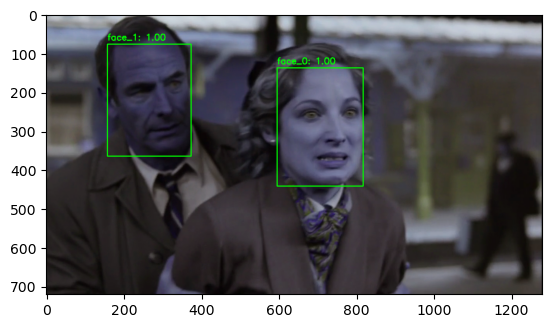

In [15]:
import matplotlib.pyplot as plt 

# check out the image 
plt.imshow(analyze_boxed)

In [16]:
# extract robson green face embedding
robson_green_face_embedding = analyze_embeddings[1]

# convert the embedding to a string friendly representation 
embedding_str =", ".join(map(str, robson_green_face_embedding))

In [ ]:
query = f"""
            SELECT 
                actor_actress, 
                about, 
                1-(facial_embedding <=>'[{embedding_str}]') AS score 
            FROM 
                masterpiece_grantchester 
            ORDER BY 
                facial_embedding <=> '[{embedding_str}]' 
            LIMIT 5;
            """

In [19]:
# query to search our postgres table for similar faces
with_score = f"""
SELECT 
    actor_actress, 
    about, 
    1-(facial_embedding <=>'[{embedding_str}]') AS score 
FROM 
    masterpiece_grantchester 
ORDER BY 
    facial_embedding <=> '[{embedding_str}]' 
LIMIT 5;
"""

In [20]:
# send the query to the database and review results and selected metadata
db.execute_query(with_score)

[('Robson Green',
  '{"About the Character: Geordie is the lovably crabby detective with a gruff exterior and heart of gold. His methodical approach to policing complements the more intuitive techniques of his vicar friends. He’s a no-nonsense, plain-speaking man who holds mental scars from serving in World War II. Geordie is the husband of Cathy Keating and a devoted father of four.","Where You’ve Seen Him Before: Aside from his work on\xa0Grantchester\xa0and\xa0Soldier Soldier, Green is also recognized for roles in\xa0Touching Evil\xa0and\xa0Reckless. He also appeared in the series Being Human alongside Poldark star Aidan Turner.","Fun Fact: Green had a brief career in the music industry as one half of the mid-90s pop duo Robson and Jerome. More recently, he and Grantchester co-star Tom Brittney had cameos as backing guitarists for Sam Fender in the North Shields’ singer’s music video.","Related Content: Read our exclusive cast interview with Green and check out his audio interview w